In [1]:
import os
import pandas as pd
import json

In [2]:
data = []

In [3]:
folder_path = './pre_dataset/files'
# Duyệt qua từng folder trong folder_path
for folder in os.listdir(folder_path):
    file_path = folder_path + '/' + folder + '/measurements.json'
    # Đọc file json
    with open(file_path) as f:
        data.append(json.load(f))

In [4]:
converted_data = {}
for item in data:
    for key, value in item.items():
        if key not in converted_data:
            converted_data[key] = []
        converted_data[key].append(value)

In [5]:
for key, values in converted_data.items():
    # Check if value contains "_tbr" and remove it
    converted_data[key] = [value.replace('_tbr', '') for value in values]

In [6]:
# Tạo DataFrame từ dữ liệu
df = pd.DataFrame(converted_data)

In [7]:
df = df.drop(columns=['race', 'profession', 'age', 'gender'])
# df['gender'] = df['gender'].map({'male': 1, 'female': 0})

In [8]:
# convert height and weight to float
df['height'] = df['height'].map(lambda x: float(x.replace('cm', '')))
df['weight'] = df['weight'].map(lambda x: float(x.replace('kg', '')))

In [9]:
# calculate bmi using height and weight, then drop height and weight columns
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df = df.drop(columns=['height', 'weight'])
df.astype(float)
df.head()

,arm_circumference_cm,arm_length_cm,back_build_cm,calf_circumference_cm,chest_circumference_cm,crotch_height_cm,front_build_cm,hips_circumference_cm,leg_length_cm,neck_circumference_cm,...,neck_waist_length_back_cm,neck_waist_length_front_cm,pelvis_circumference_cm,shoulder_length_cm,shoulder_width_cm,thigh_circumference_cm,under_chest_circumference_cm,upper_arm_length_cm,waist_circumference_cm,bmi
0,32.0,65.0,38.0,33.0,93.0,79.0,41.0,86.0,108.0,37.0,...,50.0,49.0,92.0,17.0,42.0,49.0,84.0,29.0,84.0,23.661439
1,33.0,64.0,39.0,42.0,110.0,79.0,48.0,50.0,110.0,43.0,...,50.0,54.0,111.0,15.0,39.0,61.0,102.0,31.0,99.0,27.700831
2,31.0,63.0,45.0,34.0,101.0,80.0,39.0,91.0,96.0,40.0,...,53.0,53.0,100.0,21.0,45.0,54.0,99.0,29.0,86.0,27.548209
3,24.0,55.0,33.0,34.0,79.0,77.0,31.0,70.0,95.0,33.0,...,41.0,44.0,88.0,14.0,40.0,49.0,71.0,29.0,68.0,19.382145
4,25.0,55.0,32.0,34.0,86.0,68.0,27.0,84.0,88.0,35.0,...,41.0,42.0,88.0,13.0,15.0,55.0,75.0,28.0,65.0,19.948060


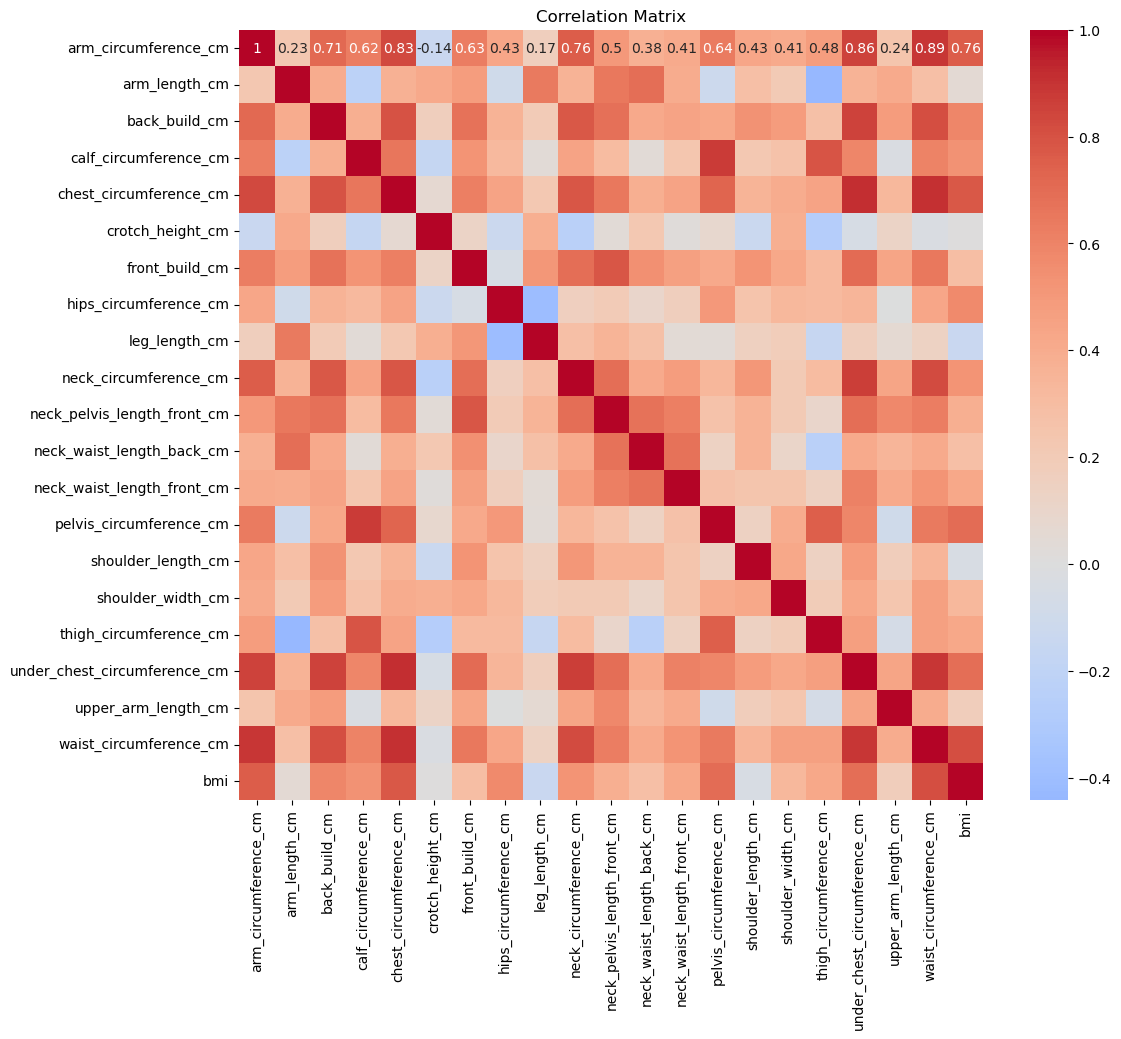

In [10]:
# visualize correlation matrix with seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

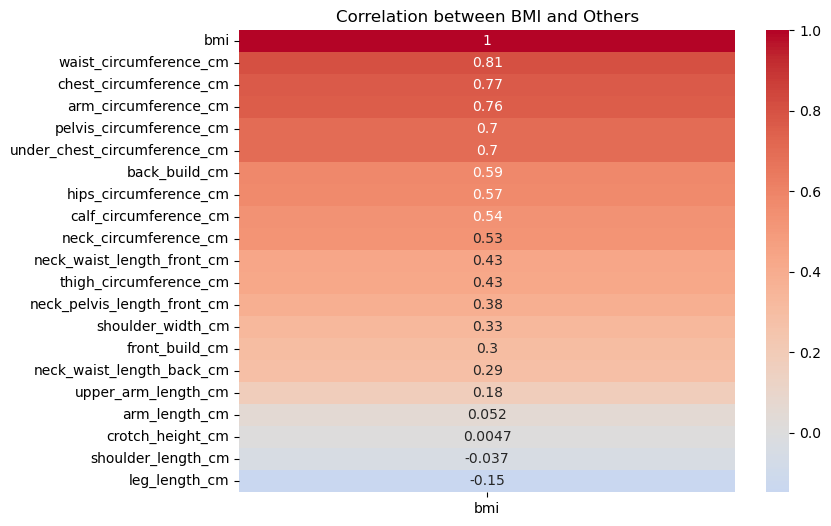

In [11]:
# visualize correlation between bmi and others, order by desc
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr()[['bmi']].sort_values(by='bmi', ascending=False), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between BMI and Others')
plt.show()


In [12]:
# features column that have correlation with bmi >= 0.
features = df.corr()[['bmi']].sort_values(by='bmi', ascending=False)
features = features[features['bmi'] >= 0.6].index.tolist()
features.remove('bmi')
features = df[features]
features.shape

(21, 5)

In [13]:
# label column is bmi
label = df['bmi']
label.shape

(21,)

In [14]:
# predict bmi from features, using svm and random forest, neurals network
# then evaluate the model using mean_absolute_error, mean_squared_error, r2_score, mape
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

# SVM
svm = SVR()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_mae = mean_absolute_error(y_test, svm_pred)
svm_mse = mean_squared_error(y_test, svm_pred)
svm_r2 = r2_score(y_test, svm_pred)
svm_mape = np.mean(np.abs((y_test - svm_pred) / y_test)) * 100

# Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)
rf_mape = np.mean(np.abs((y_test - rf_pred) / y_test)) * 100

               SVM  Random Forest
MAE       1.905660       1.936508
MSE       4.872384       4.920373
R2 Score  0.665468       0.662174
MAPE      8.516463       8.384231


<Figure size 800x600 with 0 Axes>

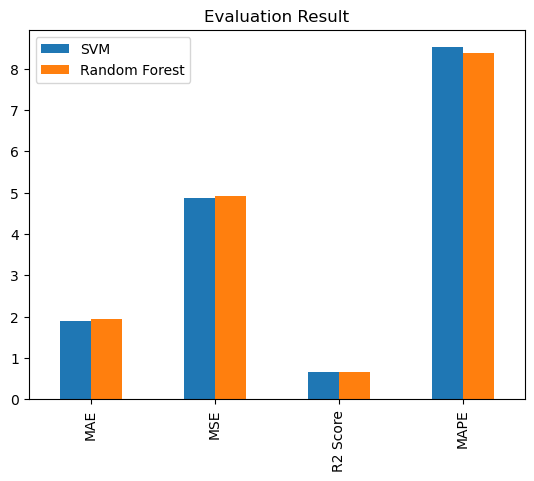

In [15]:
# use table to show the result
result = pd.DataFrame({
    'SVM': [svm_mae, svm_mse, svm_r2, svm_mape],
    'Random Forest': [rf_mae, rf_mse, rf_r2, rf_mape],
}, index=['MAE', 'MSE', 'R2 Score', 'MAPE'])
print(result)

# visualize the evaluation result
plt.figure(figsize=(8, 6))
result.plot(kind='bar')
plt.title('Evaluation Result')
plt.show()

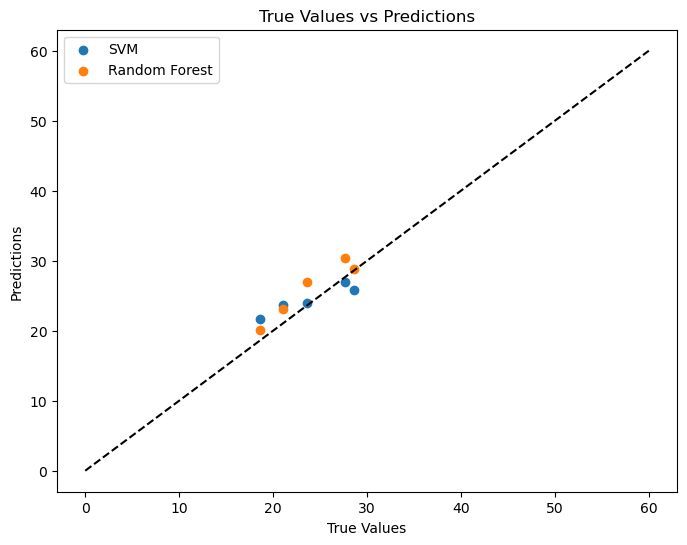

In [16]:
# plot the line and data points for each model, title for each axis
plt.figure(figsize=(8, 6))
plt.scatter(y_test, svm_pred, label='SVM')
plt.scatter(y_test, rf_pred, label='Random Forest')
plt.plot([0, 60], [0, 60], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.legend()
plt.show()